In [211]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import datetime as dt
import time
import json
from pyspark.sql import SQLContext
import json
from IPython import display
from IPython.core.display import HTML
import pandas
import time 
import numpy as np
import matplotlib.pyplot as plt 
from pyspark.sql.functions import split, explode, col

sql = SQLContext(sc)

#  NEW CASTLE HABOUR BLOCKADE (8TH MARCH 2016)
# Event Description:

On 8th March 2016 about 1,500 anti-coal protesters descended on the NSW port of Newcastle on Sunday in a bid to blockade the port and prevent exports. The world's largest coal export port, north of Sydney, was targeted by demonstrators calling for action to tackle climate change. About noon, the port was filled with kayaks paddling out to the entrance of the harbour as part of the Break Free event. The aim was for the mass flotilla to stop coal ships entering and leaving the harbour, something protesters claimed to have achieved. Police said 66 people were arrested during the "large civil disobedience" protest. In total, 57 protesters who occupied a rail bridge to block coal train at Sandgate were issued with Field Court Attendance Notices (FCANs) for remaining on enclosed lands. Pictures posted on social media showed groups of protesters lying on train tracks. The day of protest was organized by a range of groups, supported by Greenpeace and climate action group 350.org. Hundreds of Rising Tide protesters took to Newcastle Harbour for its seventh annual anti-coal port blockade. The protesters took to canoes and kayaks to block the port and deny coal ships entry for the majority of the day, the Newcastle Herald reports. 
The popular hashtags for the event were:

#breakfree    #keepitintheground    #ClimateAction     #Newcastle   #endcoal     #ClimateResistance  #quitcoal          #coal       #endfossilfuel 

# Get one Week Tweet Before the Event....

In [212]:
lol = sql.read.load(format = "au.com.d2dcrc.carbon.spark.tweets", startTime = "2016-03-07T00:00:00Z", endTime = "2016-03-07T23:59:59Z")
lol.printSchema()



displaytweets = lol.select( "author", "publicationTime", "bodyText", "locations").orderBy("author")
#pd.set_option('display.max_colwidth', 500)
#display.display(displaytweets.toPandas())b

root
 |-- key:salt: byte (nullable = true)
 |-- key:timestamp: timestamp (nullable = true)
 |-- key:id: string (nullable = true)
 |-- key:subIds: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- data: string (nullable = true)
 |-- reference: string (nullable = true)
 |-- format: string (nullable = true)
 |-- type: string (nullable = true)
 |-- source: string (nullable = true)
 |-- ingestTime: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- civilEvents: string (nullable = true)
 |-- locations: string (nullable = true)
 |-- geo: string (nullable = true)
 |-- nlp: string (nullable = true)
 |-- publicationTime: timestamp (nullable = true)
 |-- politicalParty: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- times: string (nullable = true)
 |-- bodyText: string (nullable = true)
 |-- title: string (nullable = true)
 |-- phraseList: string (nullable = true)



In [230]:
realtweet = displaytweets.select('bodyText')

In [234]:
#The following SQL statement selects all customers with a Country containing the pattern "#coal"
sqlContext.registerDataFrameAsTable(realtweet, "compareData")
sqlContext.sql("SELECT bodyText FROM compareData WHERE bodyText LIKE '%#coal%'").count() 


388

In [240]:
newpd = displaytweets.toPandas()
hashTags = newpd.where(newpd['bodyText'].str.contains('#coal')).dropna() #this works thesame as 

In [242]:
type(hashTags)
hashTags.describe() #insight show that 374 text has locations 

,author,publicationTime,bodyText,locations
count,388,388,388,388
unique,296,383,130,3
top,id:twitter.com:288010117,2016-03-07 18:17:42,RT @StopShenhua: Farmers call for Windsor to c...,
freq,8,3,52,374
first,NaN,2016-03-07 10:31:24,NaN,NaN
last,NaN,2016-03-08 10:16:24,NaN,NaN


In [244]:
type(hashTags)

pandas.core.frame.DataFrame

In [243]:
import csv

#mysave.write.csv('ididit.csv')
hashTags.to_csv('march7.csv') #This works perfectly

In [238]:
sqlContext.registerDataFrameAsTable(realtweet, "compareData1")
sqlContext.sql("SELECT bodyText FROM compareData1 WHERE bodyText LIKE '#coal%'").count() #owkring very well


0

In [237]:
#The following SQL statement selects all bodytext of tweets starting with the letter "s":
#WHERE City LIKE 's%';
sqlContext.registerDataFrameAsTable(realtweet, "compareData2")
sqlContext.sql("SELECT bodyText FROM compareData2 WHERE bodyText LIKE '%#coal'").count() #owkring very well


6

In [213]:
def get_tweets(df):
    #return rows from dadtframe
    return df.map(lambda row: row.data)

In [214]:
def get_jason(data):
    #returns a pyspark.rdd.PipelinedRDD of jason data
    return data.map(lambda data: json.loads(data))


In [215]:

def get_tweet_body(data):
    #returns a pyspark.rdd.PipelinedRDD of tweet bodies
    tweet_bodies = data.map(lambda tweet_as_json: tweet_as_json.get('body'))
    return tweet_bodies 

In [216]:
#This function obtains geo tag details from json tweets
#input: json data
#output: returns a pyspark.rdd.PipelinedRDD of tweet bodies
def get_tweet_geo(data):
    tweet_geo = data.map(lambda tweet_as_json: tweet_as_json.get('geo',"none"))
    return tweet_geo

In [217]:
def get_tweet_BodyLocation(data):
    bodys_with_location = data.filter(lambda line: 'location' in line).map(lambda line: (line.get('location', "none"),line.get('body',"none")))
    return bodys_with_location

# Specify possible HashTags relating to Event

In [218]:
def get_hashtags(jdata):
# hash_tags = jdata.flatMap(lambda line: line.split(" ")).filter(lambda word: word.startswith('#keepsydneyopen' or '#auspol' or '#ReclaimAustralia'  or '#Nolockouts' or '#nightlivesmatter' or '#keepsydneyopenrally' or '#keepsydneylate'))
 #return hash_tags 
    hash_tags = jdata.flatMap(lambda line: line.split(" ")).filter(lambda word: word.startswith('#coal'))
    return hash_tags 

In [219]:
def hashtag_counter(htags):
    hashtag_counts = htags.map(lambda hashtag: (hashtag, 1)).reduceByKey(lambda a, b: a + b)
    return hashtag_counts

In [220]:
#this fuction returns a given number of common hashtags
#inputs: list of hashtags or hashtag counter dictionary
#output: list of common hashtags 
def common_hashtags(htags,n):
    return Counter(dict(htags)).most_common(n)

In [221]:
#this fuction takes a dictionary and plots key value pairs
def plot_bargraph(d):
    %matplotlib inline
    plt.barh(range(len(d)), d.values(), align="center")
    plt.yticks(range(len(d)), list(d.keys()),rotation='horizontal')
    plt.show()

In [222]:
#df = get_data() #get twitter data for a given number of minutes

df = lol
test =get_tweets(df)
test= get_jason(test)
test=get_tweet_body(test)
hashTags = get_hashtags(test)
hashtag_counts = hashtag_counter(hashTags)

In [223]:
type(df)

pyspark.sql.dataframe.DataFrame

In [224]:
hashtag_count_list = hashtag_counts.take(500)

In [239]:
#Ten common hashtags 
#over 6000 tweets on Hashtag #coal
common_10 = common_hashtags(hashtag_count_list,50) 
print(common_10)

[('#coal', 338), ('#coal"', 15), ('#coalisamazing', 3), ('#coalisover\n', 2), ('#coal-powered', 2), ('#coalitiontounchaindogs', 1), ('#coalkings', 1), ('#coalrivervalley', 1), ('#coalplant', 1), ('#coal.', 1), ('#coalition', 1), ('#coalseamgasprotests...', 1), ('#coalash', 1), ('#coalmine', 1), ('#coal\nhttps://t.co/P3CTI3AR6h', 1), ('#coalminer', 1)]


In [226]:
type(common_10)

list

In [227]:
#for s in common_10:
#    print(s[0].ljust(8)+(str(s[1])).ljust(30))

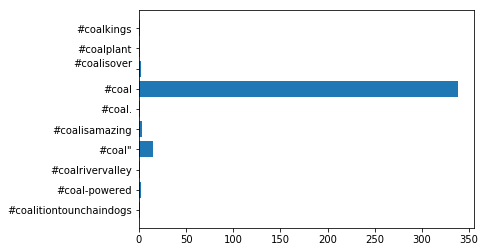

In [228]:
plot_bargraph(dict(common_10))

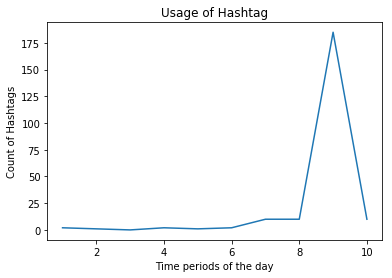

In [229]:
daylist = [1,2,3,4,5,6,7,8,9,10]
hashlist = [2,1,0,2,1,2,10,10,185,10] 
hashlist2 = [2,1,67,2,1,2,10,10,90,10] 

#daily count of hashtags

plt.plot(daylist,hashlist)
plt.title('Usage of Hashtag')
plt.xlabel('Time periods of the day')
plt.ylabel('Count of Hashtags')
#plt.scatter(days, counthash)

plt.show()

# Futher Analysis:

# Hashtags and Locations
